In [1]:
!pip install wandb
!wget https://datarepo.eng.ucsd.edu/mcauley_group/data/renttherunway/renttherunway_final_data.json.gz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.8/252.8 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.3 MB/s eta 0:00:00
--2023-12-06 00:02:36--  https://datarepo.eng.ucsd.edu/mcauley_group/data/renttherunway/renttherunway_final_data.json.gz
Resolving datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)... 132.239.8.30
Connecting to datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31493535 (30M) [application/x-gzip]
Saving to: ‘renttherunway_final_data.json.gz’

renttherunway_final 100%[===================>]  30.03M  9.87MB/s    in 3.0s    

2023-12-06 00:02:40 (9.87 MB/s) - ‘renttherunway_final_data.json.gz’ saved [31493535/31493535]



In [2]:
import gzip
import math
import numpy
import random
import sklearn
import string
from collections import defaultdict
from nltk.stem.porter import *
from sklearn import linear_model
from gensim.models import Word2Vec
import dateutil
from scipy.sparse import lil_matrix, hstack, vstack
import numpy as np
import json
import tqdm

from collections import Counter
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import optim
import torch.nn.init as init

import wandb

from sklearn.metrics import mean_squared_error

In [3]:
dataset = []

f = gzip.open("renttherunway_final_data.json.gz")
for l in f:
    d = json.loads(l)
    dataset.append(d)

f.close()

In [4]:
# Data Exploration
userCount = defaultdict(int)
itemCount = defaultdict(int)
fit_count = 0

for d in dataset:
    item_id = d['item_id']
    user_id = d['user_id']

    userCount[user_id] += 1
    itemCount[item_id] += 1

    if d['fit'] == "fit":
        fit_count += 1

unique_user = 0
unique_item = 0

for user, counts in userCount.items():
    if counts == 1:
        unique_user += 1

for item, counts in itemCount.items():
    if counts == 1:
        unique_item += 1

print(unique_user / len(userCount))
print(unique_item / len(itemCount))
print(fit_count / len(dataset))

0.6803383504939804
0.05829059829059829
0.7377949975070633


In [5]:
len(dataset)

192544

In [6]:
fits = [d["fit"] for d in dataset]

In [7]:
def plt_distribution(items):
    items_list = [d.get(items) if items in d and d[items] else "UNK" for d in dataset]
    string_counts = Counter(items_list)

    # Prepare data for plotting
    labels, values = zip(*string_counts.items())

    # Create a bar plot
    plt.bar(labels, values)

    # Adding titles and labels
    plt.title("String Occurrences")
    plt.xlabel("Strings")
    plt.ylabel("Occurrences")

    # Show the plot
    plt.show()

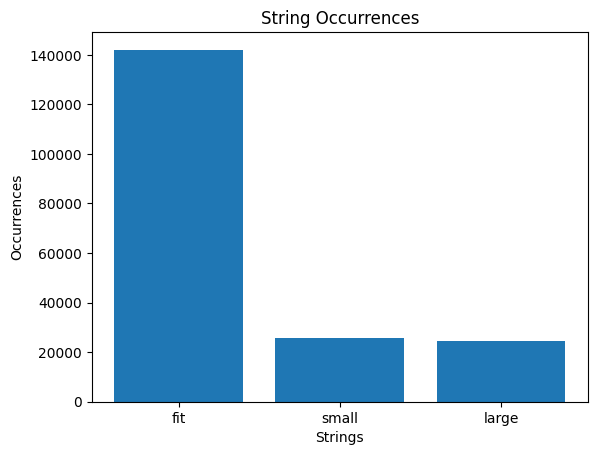

In [8]:
plt_distribution("fit")

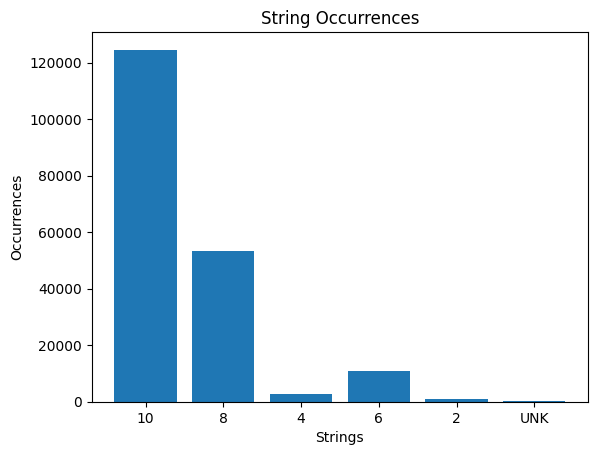

In [9]:
plt_distribution("rating")

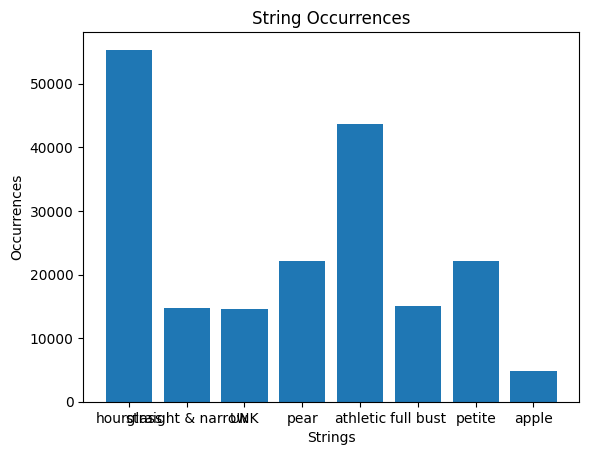

In [10]:
plt_distribution("body type")

In [11]:
def sparsity_plot(items):
    items_list = [d[items] if d[items] else "UNK" for d in dataset]
    string_counts = Counter(items_list)
    cnts_list = list(string_counts.values())
    cnts_counts = Counter(cnts_list)

    x = list(cnts_counts.keys())
    y = list(cnts_counts.values())

    x, y = zip(*sorted(zip(x, y)))

    plt.bar(x, y)

    plt.title("Number Distribution")
    plt.xlabel("Number")
    plt.ylabel("Count")

    plt.show()

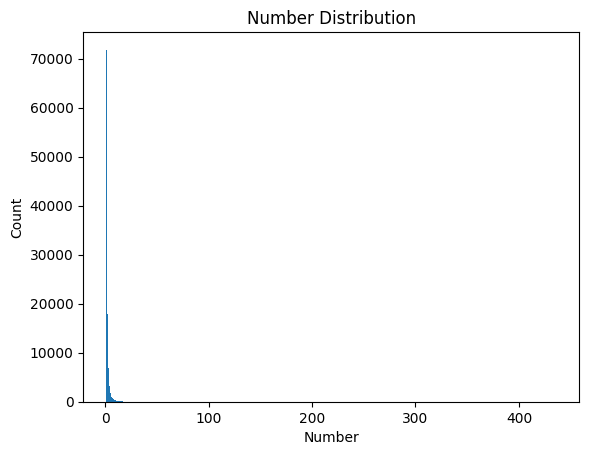

In [12]:
sparsity_plot("user_id")

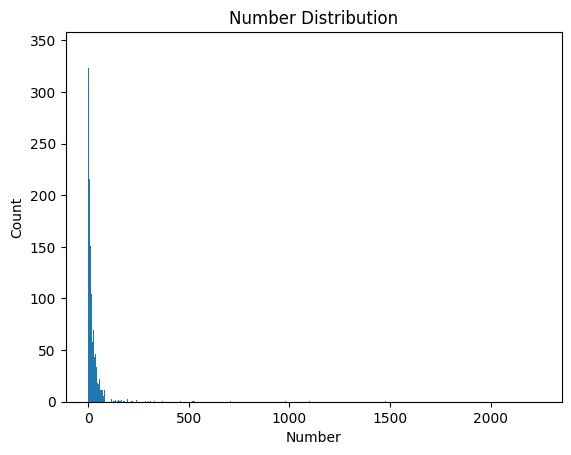

In [13]:
sparsity_plot("item_id")

In [14]:
random.seed(42)
random.shuffle(dataset)

dataNum = len(dataset)
trainNum = int(dataNum * 0.6)
validNum = int(dataNum * 0.2)

actionsTrain = dataset[:trainNum]
actionsValid = dataset[trainNum: trainNum + validNum]
actionsTest = dataset[trainNum + validNum:]

In [15]:
actionsTrain[0]

{'fit': 'large',
 'user_id': '657330',
 'bust size': '34d',
 'item_id': '2337484',
 'weight': '140lbs',
 'rating': '10',
 'rented for': 'wedding',
 'review_text': "I absolutely loved this skirt.  The leather is so buttery soft and the hem of it is a clean, raw cut, which I think makes it much classier and sleek.  It fit perfectly on my hips and but but gapped a little in the waist (but I do have a small waist for the size of my hips/butt.) . The metal detail is silver but I wore gold jewelry with it and didn't think it clashed.  So sad to give it back!",
 'body type': 'hourglass',
 'review_summary': 'Trendy Twist on a Black Pencil Skirt',
 'category': 'skirt',
 'height': '5\' 8"',
 'size': 8,
 'age': '29',
 'review_date': 'April 4, 2017'}

In [16]:
itemsPerUser = defaultdict(list)
usersPerItem = defaultdict(list)
categorySet = set()
bodyShapeSet = set()
bustSizeSet = set()

item_category = {}
global_average = 0.0

fit_dict = {
    'small': -1,
    'fit': 0,
    'large': 1,
}

# Preprocess
for action in actionsTrain:
    item_id = action['item_id']
    user_id = action['user_id']

    itemsPerUser[user_id].append(item_id)
    usersPerItem[item_id].append(user_id)

    fit = action['fit']
    global_average += fit_dict[fit]

    item_category[item_id] = action["category"]

    categorySet.add(action["category"])
    bodyShapeSet.add(action.get("body type", "UNK"))
    bustSizeSet.add(action.get("bust size"))

bodyShapeDict = dict(zip(list(bodyShapeSet), list(range(len(bodyShapeSet)))))
categoryDict = dict(zip(list(categorySet), list(range(len(categorySet)))))

global_average = global_average / len(actionsTrain)

In [17]:
maxUserNum = 5000
maxItemNum = 8000

userCount = defaultdict(int)
itemCount = defaultdict(int)

for user in itemsPerUser:
    userCount[user] = len(itemsPerUser[user])

for item in usersPerItem:
    itemCount[item] = len(usersPerItem[item])


userCounts = list(userCount.items())
sortedUser = sorted(userCounts, reverse=True, key=lambda x:x[1])[:maxUserNum]
userIDDict = dict(zip([x[0] for x in sortedUser], list(range(len(sortedUser)))))
topUsers = set([x[0] for x in sortedUser][:maxUserNum])

itemCounts = list(itemCount.items())
sortedItem = sorted(itemCounts, reverse=True, key=lambda x:x[1])[:maxItemNum]
itemIDDict = dict(zip([x[0] for x in sortedItem], list(range(len(sortedItem)))))
topItems = set([x[0] for x in sortedItem][:maxItemNum])

In [18]:
len(userIDDict)

5000

In [18]:
# utils functions
def height2inches(height):
    feet = height.split()[0][:-1]
    inch = height.split()[1][:-1]
    return int(feet) * 12 + int(inch)

def id2onehot(name, indexDict):
    feature = lil_matrix((1, len(indexDict)))
    if name in indexDict:
        feature[0, indexDict[name]] = 1

    return feature

In [20]:
# Dense Feature (without interacrtion)
def processX(actions):
    datasize = len(actions)

    features = []

    for action in tqdm.tqdm(actions):
        feature_dict = {}

        # ID one-hot feature
        item_id = action['item_id']
        user_id = action['user_id']

        item_id_one_hot = id2onehot(item_id, itemIDDict)
        user_id_one_hot = id2onehot(user_id, userIDDict)

        # Category one-hot feature
        category = action['category']
        category_one_hot = id2onehot(category, categoryDict)

        # body type one-hot feature
        body_type = action.get('body type', 'UNK')
        body_type_one_hot = id2onehot(body_type, bodyShapeDict)

        size = action.get('size', -1)
        age = int(action.get('age', -1))
        height = height2inches(action.get('height', '0\' 0"'))
        bust_size = (action.get('bust size'))
        weight = int(action.get('weight', '0lbs')[:-3])

        dense_feature = numpy.array([size, age, height, weight], dtype=numpy.float32)
        feature_vec = hstack([item_id_one_hot, user_id_one_hot, category_one_hot, dense_feature])
        features.append(feature_vec)

    return vstack(features)

def processY(actions):
    datasize = len(actions)

    labels = [fit_dict[a['fit']] for a in actions]

    return numpy.array(labels)

trainX = processX(actionsTrain)
trainY = processY(actionsTrain)
validX = processX(actionsValid)
validY = processY(actionsValid)
testX = processX(actionsTest)
testY = processY(actionsTest)

100%|██████████| 38510/38510 [00:41<00:00, 937.89it/s] 


In [21]:
trainX.shape

(115526, 10700)

In [22]:
# logistic regression (baseline 1)
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(trainX, trainY)

LinearRegression()

In [23]:
validPred = model.predict(validX)

In [26]:
def decideThreshold(predictions, labels):
    best_thresholds = None
    best_score = 0

    for thres1 in np.linspace(-1, 0, 21):
        for thres2 in np.linspace(0, 1, 21):
            predicted_labels = np.zeros_like(predictions)
            predicted_labels[predictions < thres1] = -1
            predicted_labels[predictions > thres2] = 1
            score = np.mean(predicted_labels == labels)

            if score > best_score:
                best_score = score
                best_thresholds = (thres1, thres2)

    return best_thresholds, best_score

def predict(predictions, labels, thres):
    predicted_labels = np.zeros_like(predictions)
    predicted_labels[predictions < thres[0]] = -1
    predicted_labels[predictions > thres[1]] = 1
    score = np.mean(predicted_labels == labels)

    return score, predicted_labels

def calculate_accuracy(labels, preds):
    accuracies = {}
    for label_val in [1, -1, 0]:
        total = sum([1 for x in labels if x == label_val])
        if total > 0:
            correct = sum([1 for x, y in zip(labels, preds) if x == y and x == label_val])
            accuracies[label_val] = correct / total
        else:
            accuracies[label_val] = None  # 避免除以零
    return accuracies

In [27]:
thres, best_score = decideThreshold(validPred, validY)
testPred = model.predict(testX)
testScore, predLabels = predict(testPred, testY, thres)
print(testScore)
print(thres)

0.749623474422228
(-0.6, 0.55)


In [29]:
Counter(predLabels)

Counter({0.0: 36087, -1.0: 1100, 1.0: 1323})

In [30]:
Counter(testY)

Counter({0: 28434, -1: 5197, 1: 4879})

In [46]:
print(calculate_accuracy(testY, predLabels))
print(mean_squared_error(testY, testPred))

{1: 0.0313588850174216, -1: 0.03386569174523764, 0: 0.9344798480692129}
0.21358776380395814


In [19]:
# Feature for torch network
def processNNX(actions):
    datasize = len(actions)

    features = []

    for action in tqdm.tqdm(actions):
        feature_dict = {}

        # ID one-hot feature
        item_id = action['item_id']
        user_id = action['user_id']

        # item_id_one_hot = id2onehot(item_id, itemIDDict)
        # user_id_one_hot = id2onehot(user_id, userIDDict)

        feature_dict['item_id'] = itemIDDict.get(item_id, maxItemNum)
        feature_dict['user_id'] = userIDDict.get(user_id, maxUserNum)

        # Category one-hot feature
        category = action['category']
        category_one_hot = id2onehot(category, categoryDict).toarray().reshape(-1)

        feature_dict['category_id'] = categoryDict.get(category, 0)

        # body type one-hot feature
        body_type = action.get('body type', 'UNK')
        body_type_one_hot = id2onehot(body_type, bodyShapeDict).toarray().reshape(-1)

        feature_dict['body_type_id'] = bodyShapeDict.get(body_type, 0)

        size = action.get('size', -1)
        age = int(action.get('age', -1))
        height = height2inches(action.get('height', '0\' 0"'))
        # bust_size = action.get('bust size', 'UNK')
        weight = int(action.get('weight', '0lbs')[:-3])

        dense_feature = numpy.array([size, age, height, weight], dtype=numpy.float32)
        dense_feature = numpy.hstack([category_one_hot, body_type_one_hot, dense_feature])
        feature_dict['dense'] = dense_feature

        features.append(feature_dict)

    return features

def processY(actions):
    datasize = len(actions)

    labels = [fit_dict[a['fit']] for a in actions]

    return numpy.array(labels)

trainX = processNNX(actionsTrain)
trainY = processY(actionsTrain)
validX = processNNX(actionsValid)
validY = processY(actionsValid)
testX = processNNX(actionsTest)
testY = processY(actionsTest)

100%|██████████| 38510/38510 [00:02<00:00, 13138.64it/s]


In [ ]:
trainX[100]

{'item_id': 299,
 'user_id': 5000,
 'category_id': 20,
 'body_type_id': 2,
 'dense': array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,  12.,  56.,  64., 135.])}

In [20]:
# Pytorch Dataset
class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

trainDataset = CustomDataset(trainX, trainY)
trainDataloader = DataLoader(trainDataset, batch_size=8192, shuffle=True)

validDataset = CustomDataset(validX, validY)
validDataloader = DataLoader(validDataset, batch_size=4096, shuffle=True)

testDataset = CustomDataset(testX, testY)
testDataLoader = DataLoader(testDataset, batch_size=4096, shuffle=True)

In [21]:
# Latent Factor Model (baseline 2)
class LatentModel(nn.Module):
    def __init__(self, embedding_size):
        super(LatentModel, self).__init__()

        self.embedding_size = embedding_size

        self.beta_u = torch.nn.Embedding(maxUserNum + 1, 1)
        self.beta_i = torch.nn.Embedding(maxItemNum + 1, 1)

        self.user_embedding = torch.nn.Embedding(maxUserNum + 1, embedding_size)
        self.item_embedding = torch.nn.Embedding(maxItemNum + 1, embedding_size)

        init.normal_(self.user_embedding.weight, mean=0.0, std=1e-3)
        init.normal_(self.item_embedding.weight, mean=0.0, std=1e-3)
        init.normal_(self.beta_u.weight, mean=0.0, std=1e-3)
        init.normal_(self.beta_i.weight, mean=0.0, std=1e-3)

        self.alpha = torch.nn.Parameter(torch.tensor(global_average))

    def forward(self, user_id, item_id):
        embedded_user = self.user_embedding(user_id)
        embedded_item = self.item_embedding(item_id)

        beta_u_t = self.beta_u(user_id).squeeze()
        beta_i_t = self.beta_i(item_id).squeeze()

        product = (embedded_user * embedded_item).sum(axis=1)

        pred = beta_u_t + beta_i_t + self.alpha + product
        return pred

    def get_loss(self, user_id, item_id, y, lamb):
        pred = self.forward(user_id, item_id)
        acc_loss = torch.sum((pred - y) ** 2)

        regularization = lamb * (
            torch.norm(model.beta_u.weight) ** 2 + \
            torch.norm(model.beta_i.weight) ** 2 + \
            torch.norm(self.user_embedding.weight) ** 2 + \
            torch.norm(self.item_embedding.weight) ** 2
        )

        return acc_loss + regularization


In [22]:
def get_device():
    # return "cpu"
    return f"cuda:0" if torch.cuda.is_available() else "cpu"

embedding_size = 6
lr = 1e-3
lamb = 1e-2

device = get_device()
model = LatentModel(embedding_size).to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)

In [23]:
wandb.login(key='615cc5ff71e9bda47784da5f75acd909681f4f0b')
wandb.init(project="258_assignment_2",config={
          "learning_rate": lr,
          "lamb": lamb,
           "embedding_size": embedding_size
})

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: keterw (ece_285). Use `wandb login --relogin` to force relogin


In [24]:
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    for batch_x, batch_y in tqdm.tqdm(trainDataloader):
        batch_y = batch_y.to(device).to(torch.float32)

        loss = model.get_loss(
            batch_x['user_id'].to(device),
            batch_x['item_id'].to(device),
            batch_y,
            lamb
        )

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        wandb.log({"loss": loss.item() / batch_y.shape[0]})



    model.eval()
    all_y = []
    all_pred = []
    for batch_x, batch_y in tqdm.tqdm(validDataloader):
        batch_y = batch_y.to(device).to(torch.float32)
        predictions = model(
            batch_x['user_id'].to(device),
            batch_x['item_id'].to(device)
        )
        all_pred.append(predictions)
        all_y.append(batch_y)

    from sklearn.metrics import mean_squared_error
    MSE = mean_squared_error(
            torch.cat(all_y).detach().cpu().numpy(),
            torch.cat(all_pred).detach().cpu().numpy()
        )
    wandb.log({"validation_MSE": MSE})

100%|██████████| 10/10 [00:00<00:00, 23.93it/s]


In [39]:
model.eval()
all_y = []
all_pred = []
for batch_x, batch_y in tqdm.tqdm(validDataloader):
    batch_y = batch_y.to(device).to(torch.float32)
    predictions = model(
        batch_x['user_id'].to(device),
        batch_x['item_id'].to(device)
    )
    all_pred.append(predictions)
    all_y.append(batch_y)

all_pred = torch.cat(all_pred, axis=0).cpu().detach().numpy()
all_y = torch.cat(all_y, axis=0).cpu().detach().numpy()

100%|██████████| 10/10 [00:00<00:00, 37.16it/s]


In [40]:
thres, score = decideThreshold(all_pred, all_y)

In [41]:
model.eval()
all_y = []
all_pred = []
for batch_x, batch_y in tqdm.tqdm(testDataLoader):
    batch_y = batch_y.to(device).to(torch.float32)
    predictions = model(
        batch_x['user_id'].to(device),
        batch_x['item_id'].to(device)
    )
    all_pred.append(predictions)
    all_y.append(batch_y)

all_pred = torch.cat(all_pred, axis=0).cpu().detach().numpy()
all_y = torch.cat(all_y, axis=0).cpu().detach().numpy()

100%|██████████| 10/10 [00:01<00:00,  5.98it/s]


In [42]:
testScore, predLabels = predict(all_pred, all_y, thres)

In [43]:
testScore

0.7502986237340951

In [45]:
print(calculate_accuracy(all_y, predLabels))
print(mean_squared_error(all_y, all_pred))

{1: 0.14224226275876203, -1: 0.1487396574947085, 0: 0.9645846521769712}
0.21506965


In [48]:
class WideAndDeep(nn.Module):
    def __init__(self, embedding_size, num_dense, hidden_units):
        super(WideAndDeep, self).__init__()

        self.embedding_size = embedding_size

        self.beta_u = torch.nn.Embedding(maxUserNum + 1, 1)
        self.beta_i = torch.nn.Embedding(maxItemNum + 1, 1)

        self.user_embedding = torch.nn.Embedding(maxUserNum + 1, embedding_size)
        self.item_embedding = torch.nn.Embedding(maxItemNum + 1, embedding_size)

        init.normal_(self.user_embedding.weight, mean=0.0, std=1e-3)
        init.normal_(self.item_embedding.weight, mean=0.0, std=1e-3)
        init.normal_(self.beta_u.weight, mean=0.0, std=1e-3)
        init.normal_(self.beta_i.weight, mean=0.0, std=1e-3)

        self.alpha = torch.nn.Parameter(torch.tensor(global_average))

        # Deep Tower
        # hidden layers
        self.fc_layers = nn.ModuleList()
        input_dim = embedding_size + embedding_size + num_dense
        for hidden_unit in hidden_units:
            self.fc_layers.append(nn.Linear(input_dim, hidden_unit))
            input_dim = hidden_unit

        # output layer
        self.output = nn.Linear(input_dim, 1)

    def forward(self, user_id, item_id, dense):
        embedded_user = self.user_embedding(user_id)
        embedded_item = self.item_embedding(item_id)

        beta_u_t = self.beta_u(user_id).squeeze()
        beta_i_t = self.beta_i(item_id).squeeze()

        product = (embedded_user * embedded_item).sum(axis=1)

        # dense tower
        deep_input = torch.cat([embedded_user, embedded_item, dense], dim=1)
        for layer in self.fc_layers:
            deep_input = F.relu(layer(deep_input))

        deep_output = self.output(deep_input).squeeze()

        pred = beta_u_t + beta_i_t + self.alpha + product + deep_output
        return pred

    def get_loss(self, user_id, item_id, dense, y, lamb):
        pred = self.forward(user_id, item_id, dense)
        acc_loss = torch.sum((pred - y) ** 2)

        regularization = lamb * (
            torch.norm(self.beta_u.weight) ** 2 + \
            torch.norm(self.beta_i.weight) ** 2 + \
            torch.norm(self.user_embedding.weight) ** 2 + \
            torch.norm(self.item_embedding.weight) ** 2
        )

        return acc_loss + regularization

In [49]:
def get_device():
    # return "cpu"
    return f"cuda:0" if torch.cuda.is_available() else "cpu"

embedding_size = 6
lr = 1e-3
lamb = 1e-2

device = get_device()
wdModel = WideAndDeep(embedding_size, len(trainX[0]['dense']), [32, 16, 4]).to(device)

optimizer = optim.Adam(wdModel.parameters(), lr=lr)

In [50]:
wandb.login(key='615cc5ff71e9bda47784da5f75acd909681f4f0b')
wandb.init(project="258_assignment_2",
           name="w&d",config={
          "learning_rate": lr,
          "lamb": lamb,
           "embedding_size": embedding_size
})

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


loss,█▇▇▇▆▅▇▅▅▄▄▃▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▃▂
validation_MSE,██▇▇▆▅▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,0.17846
validation_MSE,0.21529


In [51]:
num_epochs = 50

for epoch in range(num_epochs):
    wdModel.train()
    for batch_x, batch_y in tqdm.tqdm(trainDataloader):
        batch_y = batch_y.to(device).to(torch.float32) #.to(torch.float32)
        loss = wdModel.get_loss(
            batch_x['user_id'].to(device),
            batch_x['item_id'].to(device),
            batch_x['dense'].to(device).to(torch.float32),
            batch_y,
            lamb,
        )

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        wandb.log({"loss": loss.item() / batch_y.shape[0]})



    wdModel.eval()
    all_y = []
    all_pred = []
    for batch_x, batch_y in tqdm.tqdm(validDataloader):
        batch_y = batch_y.to(device).to(torch.float32)
        predictions = wdModel(
            batch_x['user_id'].to(device),
            batch_x['item_id'].to(device),
            batch_x['dense'].to(device).to(torch.float32)
        )
        all_pred.append(predictions)
        all_y.append(batch_y)

    from sklearn.metrics import mean_squared_error
    MSE = mean_squared_error(
            torch.cat(all_y).detach().cpu().numpy(),
            torch.cat(all_pred).detach().cpu().numpy()
        )
    wandb.log({"validation_MSE": MSE})

100%|██████████| 10/10 [00:00<00:00, 17.54it/s]


In [55]:
wdModel.eval()
all_y = []
all_pred = []
for batch_x, batch_y in tqdm.tqdm(validDataloader):
    batch_y = batch_y.to(device).to(torch.float32)
    predictions = wdModel(
        batch_x['user_id'].to(device),
        batch_x['item_id'].to(device),
        batch_x['dense'].to(device).to(torch.float32)
    )
    all_pred.append(predictions)
    all_y.append(batch_y)

from sklearn.metrics import mean_squared_error
MSE = mean_squared_error(
        torch.cat(all_y).detach().cpu().numpy(),
        torch.cat(all_pred).detach().cpu().numpy()
    )
all_pred = torch.cat(all_pred, axis=0).cpu().detach().numpy()
all_y = torch.cat(all_y, axis=0).cpu().detach().numpy()

100%|██████████| 10/10 [00:00<00:00, 15.81it/s]


In [56]:
thres, score = decideThreshold(all_pred, all_y)

In [58]:
wdModel.eval()
all_y = []
all_pred = []
for batch_x, batch_y in tqdm.tqdm(testDataLoader):
    batch_y = batch_y.to(device).to(torch.float32)
    predictions = wdModel(
        batch_x['user_id'].to(device),
        batch_x['item_id'].to(device),
        batch_x['dense'].to(device).to(torch.float32)
    )
    all_pred.append(predictions)
    all_y.append(batch_y)

from sklearn.metrics import mean_squared_error
MSE = mean_squared_error(
        torch.cat(all_y).detach().cpu().numpy(),
        torch.cat(all_pred).detach().cpu().numpy()
    )
all_pred = torch.cat(all_pred, axis=0).cpu().detach().numpy()
all_y = torch.cat(all_y, axis=0).cpu().detach().numpy()

100%|██████████| 10/10 [00:00<00:00, 10.91it/s]


In [59]:
testScore, predLabels = predict(all_pred, all_y, thres)

In [60]:
testScore

0.7529992209815632

In [61]:
print(calculate_accuracy(all_y, predLabels))
print(mean_squared_error(all_y, all_pred))

{1: 0.15044066407050624, -1: 0.14585337694823938, 0: 0.967363016107477}
0.20946957
